In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import pickle
from scipy.sparse import load_npz

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna
import wandb
import numpy as np
import pandas as pd
import scipy.sparse as sp
from pathlib import Path
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define directories
current_dir = Path.cwd()
encoded_dir = current_dir.parent / "data" / "encoded"
user_item_dir = current_dir.parent / "data" / "pre_process"
pairwise_output_dir = current_dir.parent / "data" / "pairwise"

# Load user-item interaction matrix
user_item_matrix = sp.load_npz(user_item_dir / 'user_item_matrix.npz')

### Pairwise with timestamp

#### Statistics

In [5]:
item_popularity = np.array(user_item_matrix.sum(axis=0)).flatten()
item_ids = np.arange(user_item_matrix.shape[1])

In [13]:
import numpy as np
print("Len:", len(item_popularity))
print("Min:", np.min(item_popularity))
print("Max:", np.max(item_popularity))
print("Mean:", np.mean(item_popularity))
print("Median:", np.median(item_popularity))
print("Standard Deviation:", np.std(item_popularity))


Len: 198771
Min: 14.0
Max: 28470.0
Mean: 198.4416791181812
Median: 86.0
Standard Deviation: 483.1663645682768


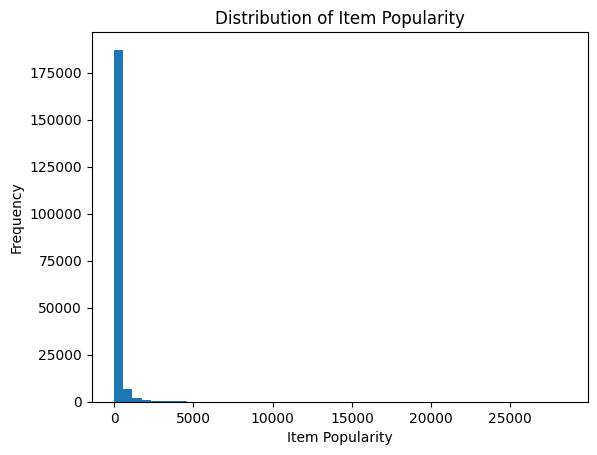

In [10]:
import matplotlib.pyplot as plt

plt.hist(item_popularity, bins=50)  # Adjust bins as needed
plt.xlabel('Item Popularity')
plt.ylabel('Frequency')
plt.title('Distribution of Item Popularity')
plt.show()


### Load interactions and mappings

In [3]:
current_dir = Path.cwd()
user_item_file_path = current_dir.parent / "data" / "data_and_test_files" / "user_item_rating_table_train.csv"
df2 = pd.read_csv(user_item_file_path,index_col=0)
# Load user and item mapping:
user_mapping_path = current_dir.parent / "data" / "pre_process" / "user_mapping.pkl"
item_mapping_path = current_dir.parent / "data" / "pre_process" / "item_mapping.pkl"
import pickle
# Load user and item mappings
with open(user_mapping_path, 'rb') as f:
    user_mapping = pickle.load(f)

with open(item_mapping_path, 'rb') as f:
    item_mapping = pickle.load(f)

# Add numeric indices to the DataFrame
df2['user_idx'] = df2['user_id'].map(user_mapping)
df2['item_idx'] = df2['parent_asin'].map(item_mapping)
df2

,user_id,parent_asin,rating,timestamp,user_idx,item_idx
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B009RTBRVG,5.0,1349041740000,0,0
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B003MZ01CM,1.0,1370958618000,0,1
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07L6QT33F,5.0,1440038761000,0,2
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07V6PKCCG,3.0,1483320893000,0,3
5,AGGZ357AO26RQZVRLGU4D4N52DZQ,B0BNP511CS,5.0,1490800837000,0,4
...,...,...,...,...,...,...
10563583,AEQHNMSCENA2TJAJEFK5SFI3ZKXA,B09G9THPC6,5.0,1692552496934,1096899,92761
10563584,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B088D217BQ,1.0,1600792118191,1096900,183765
10563585,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B07WV5H4DN,1.0,1615811081145,1096900,155119
10563587,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B0BL3PQHR4,4.0,1693494834857,1096900,25515


### Create the pairwise dataset and save with chunks

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pathlib import Path
import pickle

# Ensure 'user_idx', 'item_idx', 'timestamp', and 'rating' columns exist and drop rows with missing values
df2.dropna(subset=['user_idx', 'item_idx', 'timestamp', 'rating'], inplace=True)

# Create a user-item matrix with actual ratings
user_item_matrix = csr_matrix((df2['rating'], (df2['user_idx'], df2['item_idx'])))

item_popularity = np.array((user_item_matrix != 0).sum(axis=0)).flatten()
item_ids = df2['item_idx'].unique()

# Create pairwise training data
popularity_prob = item_popularity / item_popularity.sum()

pairwise_data = []
num_users = user_item_matrix.shape[0]

chunk_size = 100_000  # Adjust the chunk size based on available memory
output_dir = Path.cwd().parent / "data" / "pairwise"
output_dir.mkdir(parents=True, exist_ok=True)
csv_path = output_dir / "pairwise_data.csv"
pkl_path = output_dir / "pairwise_data.pkl"

for user_id in tqdm(range(num_users), desc="Processing Users"):
    user_interactions = df2[df2['user_idx'] == user_id]
    interacted_items = set(user_interactions['item_idx'])

    if not interacted_items:
        continue

    for _, row in user_interactions.iterrows():
        item1 = row['item_idx']
        interaction_timestamp = row['timestamp']
        rating = row['rating']

        # Sample a negative item based on popularity
        while True:
            item2 = np.random.choice(item_ids, p=popularity_prob)
            if item2 not in interacted_items:
                break

        # Randomly shuffle item1 and item2
        if np.random.rand() > 0.5:
            item1, item2 = item2, item1

        label = item1 if item1 in interacted_items else item2

        pairwise_data.append([user_id, item1, item2, label, interaction_timestamp, rating])

        # Save chunk to CSV and pickle
        if len(pairwise_data) >= chunk_size:
            pairwise_df = pd.DataFrame(pairwise_data, columns=["user_id", "item1_id", "item2_id", "label", "timestamp", "rating"])

            # Append to CSV
            pairwise_df.to_csv(csv_path, mode='a', header=not csv_path.exists(), index=False)

            # Append to pickle (faster for large data)
            with open(pkl_path, 'ab') as f:
                pickle.dump(pairwise_df, f)

            # Clear the memory
            pairwise_data.clear()

# Save the final chunk
if pairwise_data:
    pairwise_df = pd.DataFrame(pairwise_data, columns=["user_id", "item1_id", "item2_id", "label", "timestamp", "rating"])

    # Append to CSV
    pairwise_df.to_csv(csv_path, mode='a', header=not csv_path.exists(), index=False)

    # Append to pickle
    with open(pkl_path, 'ab') as f:
        pickle.dump(pairwise_df, f)

print(f"Saved pairwise training data to: \n- CSV: {csv_path}\n- PKL: {pkl_path}")


Processing Users:  58%|█████▊    | 634522/1096901 [3:53:02<2:19:45, 55.14it/s]]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Processing Users: 100%|██████████| 1096901/1096901 [6:17:04<00:00, 48.48it/s]  


Saved pairwise training data to: 
- CSV: /storage/yahlly/RecSys/data/pairwise/pairwise_training_data3.csv
- PKL: /storage/yahlly/RecSys/data/pairwise/pairwise_training_data3.pkl


### Load the pairwise df and split to train/val:

In [14]:
pairwise_data_path= current_dir.parent / "data" / "pairwise"/"pairwise_data.csv"
pairwise_df_all = pd.read_csv(pairwise_data_path)

In [16]:
# Group interactions by user and split
grouped = pairwise_df_all.groupby("user_id")

# Initialize lists for splits
train_data = []
val_data = []
m=1
for user_idx, group in tqdm(grouped):
    interactions = group.sort_values(by="timestamp") # Sort within each user's interactions by timestamp
    num_interactions = len(interactions)

    # Split indices
    val_split_idx = -m

    # Append splits
    val_data.append(interactions.iloc[val_split_idx:])
    train_data.append(interactions.iloc[:val_split_idx])
train_data_df = pd.concat(train_data)
val_data_df = pd.concat(val_data)


100%|██████████| 1096901/1096901 [04:15<00:00, 4290.34it/s]


In [17]:
train_data_df

,user_id,item1_id,item2_id,label,timestamp,rating
0,0,0,13349,0,1349041740000,5.0
1,0,22959,1,1,1370958618000,1.0
2,0,97562,2,2,1440038761000,5.0
3,0,23003,3,3,1483320893000,3.0
5,1,179127,5,5,1600753653091,5.0
...,...,...,...,...,...,...
9127370,1096899,26803,32852,32852,1692552324736,5.0
9127371,1096899,177842,10643,10643,1692552357767,5.0
9127373,1096900,183765,86867,183765,1600792118191,1.0
9127374,1096900,155119,99585,155119,1615811081145,1.0


In [18]:
val_data_df

,user_id,item1_id,item2_id,label,timestamp,rating
4,0,16177,4,4,1490800837000,5.0
10,1,10,174536,10,1676601720832,2.0
16,2,42860,16,16,1588626339041,5.0
29,3,20877,29,29,1605455790941,5.0
41,4,17870,41,41,1638039645551,5.0
...,...,...,...,...,...,...
9127357,1096896,197,11404,11404,1693892929945,5.0
9127362,1096897,32215,161020,161020,1617640776113,5.0
9127367,1096898,9974,33337,9974,1691348903005,5.0
9127372,1096899,45300,92761,92761,1692552496934,5.0


#### Save train/val

In [20]:
train_data_df.to_csv(pairwise_output_dir / "pairwise_train.csv", index=False)

In [21]:
val_data_df.to_csv(pairwise_output_dir / "pairwise_val.csv", index=False)